### Introduction
Transform target to price per area

### Import packages

In [1]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('../dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['price_per_area'] = df['total_price'] / df['building_area']
    df['log_price_per_area'] = np.log1p(df['price_per_area'])
    df['discrete_log_price_per_area'] = df['log_price_per_area']
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    return np.clip(np.expm1(y_pred), 0, None) * df['building_area']

In [7]:
df = target_transform(df)

In [9]:
# transformed target fit by the model
col_model_target = 'log_price_per_area'

In [10]:
df.check()

,building_id,building_material,city,txn_dt,total_floor,building_type,building_use,building_complete_dt,parking_way,parking_area,...,XIV_5000,XIV_index_5000,XIV_10000,XIV_index_10000,XIV_MIN,total_price,target,price_per_area,log_price_per_area,discrete_log_price_per_area
0,e3mMIMR3JJqCaXz1,8,21,18674.0,4.0,3,2,6271.0,2,NaN,...,2483.0,1,6011.0,1,34.469803,6.476038e+05,13.381036,1.894589e+05,12.151933,12.151933
1,LgwzgklNvy4QCtq5,8,7,18800.0,5.0,1,2,7885.0,2,NaN,...,15872.0,1,32221.0,1,40.073574,3.321452e+06,15.015913,8.218753e+05,13.619346,13.619346
2,ucIR2NLLsC3T650L,8,7,19289.0,4.0,1,2,6028.0,2,NaN,...,15760.0,1,32228.0,1,54.462082,9.570885e+06,16.074236,1.713898e+06,14.354281,14.354281
3,jre1pJhcQj91Kdky,8,21,20385.0,24.0,0,2,18325.0,0,NaN,...,2568.0,1,7271.0,1,99.628967,1.421501e+07,16.469809,1.048070e+06,13.862462,13.862462
4,rQpYpY9nRG7X5mmr,1,21,20657.0,2.0,4,2,6880.0,2,NaN,...,2587.0,1,7442.0,1,124.131233,7.627120e+05,13.544637,1.626908e+05,11.999613,11.999613
59995,Oh5Hwr9LrWApC2mr,1,5,19040.0,2.0,4,2,9193.0,2,NaN,...,1435.0,1,4611.0,1,145.279663,9.870214e+05,13.802448,1.461375e+05,11.892310,11.892310
59996,PiOgZqfsDVlTq1zs,8,13,19706.0,14.0,2,5,17168.0,0,3.738412,...,5659.0,1,22826.0,1,18.814999,1.572522e+07,16.570776,2.935570e+06,14.892412,14.892412
59997,FQmlgGohzzWuKUzu,8,7,19901.0,11.0,0,2,13729.0,0,NaN,...,13252.0,1,32687.0,1,94.799591,1.181540e+07,16.284914,1.436760e+06,14.177902,14.177902
59998,zjzfMwXhDswdEaI2,8,13,19975.0,5.0,1,2,7063.0,2,NaN,...,5317.0,1,21087.0,1,33.104580,1.808500e+07,16.710594,2.071998e+06,14.544024,14.544024
59999,iN4H6wBMtvJpF0SN,8,7,20385.0,5.0,1,2,8310.0,2,NaN,...,15417.0,1,32826.0,1,47.509876,8.510296e+06,15.956787,1.588694e+06,14.278423,14.278423


shape = (60000, 239)


In [13]:
df['log_price_per_area'].max(), df['log_price_per_area'].min(), df['log_price_per_area'].max() - df['log_price_per_area'].min()

(19.847359, 10.036508, 9.810851)

In [15]:
print('Original possible target values:', len(df['log_price_per_area'].value_counts()))

Original possible values: 33397


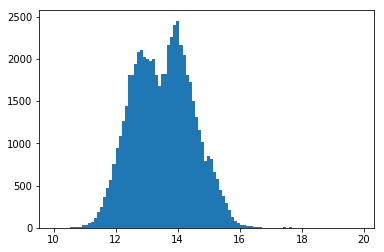

In [11]:
plt.hist(df['log_price_per_area'], bins=100)
plt.show()

### Feat engineering

In [12]:
from feature_engineering import CategoricalColumnsEncoder

In [13]:
class FeatureEngineering():
    def __init__(self): pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [14]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
             }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

#### Round 1

In [15]:
%%time
params_gsearch1 = {'num_leaves': [63, 255, 511],           # may reduce in dim-reduction exp
                   'feature_fraction': [0.5, 0.75, 1.0],
                   'min_data_in_leaf': [5, 20, 50]
                   }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
    
    # grid search
    for values in itertools.product(*[params_gsearch1[key] for key in params_gsearch1]):
        params = params_fix.copy()
        params.update( dict(zip(params_gsearch1.keys(), values)) )
        print('params:', params)

        model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
        
        y_pred = model.predict(df_val[cols_feats])
        
        y_pred_final = target_inverse_transform(df_val, y_pred)
            
        score = cal_score(df_val['total_price'], y_pred_final)
        print(score)
        tuple_params = tuple(params.items())
        gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results1 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results1.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.010476
[4000]	valid_0's mape: 0.0100779
[6000]	valid_0's mape: 0.00991591
[8000]	valid_0's mape: 0.00982109
[10000]	valid_0's mape: 0.00976737
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00976737
5586.864452488896
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 0.5, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.010462
[4000]	valid_0's mape: 0.0100658
[6000]	valid_0's mape: 0.00990772
[8000]	valid_0's mape: 0.00982835
[10000]	valid_0's mape: 0.00978246
Did not meet early stopping. Best iteration is:
[10000]	val

5622.8646092666595
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.009933
[4000]	valid_0's mape: 0.00982479
[6000]	valid_0's mape: 0.00979995
[8000]	valid_0's mape: 0.0097928
[10000]	valid_0's mape: 0.00978898
Did not meet early stopping. Best iteration is:
[9979]	valid_0's mape: 0.00978896
5595.864622741124
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 1.0, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0099666
[4000]	valid_0's mape: 0.00987318
[6000]	valid_0's mape: 0.00984979
[8000]	valid_0's mape: 0.00984257
Early stopping, best iteration is:
[8877]	valid_0's mape: 0.00984139
5561.863703507266
p

[2000]	valid_0's mape: 0.0104996
[4000]	valid_0's mape: 0.0101608
[6000]	valid_0's mape: 0.0100286
[8000]	valid_0's mape: 0.0099632
[10000]	valid_0's mape: 0.00992246
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00992246
5496.864177801391
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 1.0, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0105554
[4000]	valid_0's mape: 0.0101831
[6000]	valid_0's mape: 0.0100396
[8000]	valid_0's mape: 0.00996549
[10000]	valid_0's mape: 0.00992237
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00992237
5514.864377248274
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 63, 'feature_fraction': 1.0, 'min_data_in_leaf': 20}
Training until validation scores don't i

[2000]	valid_0's mape: 0.00974658
[4000]	valid_0's mape: 0.00970705
[6000]	valid_0's mape: 0.00970076
[8000]	valid_0's mape: 0.00969881
[10000]	valid_0's mape: 0.00969825
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00969825
5674.867425920471
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.75, 'min_data_in_leaf': 20}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00975725
[4000]	valid_0's mape: 0.00972997
[6000]	valid_0's mape: 0.00972575
[8000]	valid_0's mape: 0.00972457
[10000]	valid_0's mape: 0.00972383
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00972383
5662.867083466638
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.75, 'min_data_in_leaf': 50}
Training until validation sc

[6000]	valid_0's mape: 0.00969015
[8000]	valid_0's mape: 0.00968244
[10000]	valid_0's mape: 0.00967847
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00967847
5664.864616487181
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 50}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00983804
[4000]	valid_0's mape: 0.00972818
[6000]	valid_0's mape: 0.00970717
[8000]	valid_0's mape: 0.00970089
[10000]	valid_0's mape: 0.00969902
Did not meet early stopping. Best iteration is:
[9932]	valid_0's mape: 0.00969897
5653.864084778798
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.75, 'min_data_in_leaf': 5}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00992638
[

In [16]:
display(gsearch_results1)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 511),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5)),
  5700.8655877734445,
  [5690.86538645132, 5726.867543803216, 5684.863833065795]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5)),
  5688.866965621278,
  [5697.8669259865555, 5693.86881620957, 5674.865154667709]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 20)),
  5684.200011854174,
  [5684.866969783443, 5702.868449291899, 5664.864616487181]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_

#### Round 2

In [17]:
%%time
params_gsearch2 = {'lambda_l1': [0, 0.01, 0.1],
                   'lambda_l2': [0, 0.01, 0.1]
                  }

gsearch = {}
folds = KFold(n_splits=3, shuffle=True, random_state=246)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    # grid search
    # pick top 3 params from round 1
    for result1 in gsearch_results1[:3]:
        params1 = dict(result1[0])
        for values in itertools.product(*[params_gsearch2[key] for key in params_gsearch2]):
            params = params1.copy()
            params.update( dict(zip(params_gsearch2.keys(), values)) )
            print('params:', params)

            model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
            
            y_pred = model.predict(df_val[cols_feats])

            y_pred_final = target_inverse_transform(df_val, y_pred)

            score = cal_score(df_val['total_price'], y_pred_final)
            print(score)
            tuple_params = tuple(params.items())
            gsearch[tuple_params] = gsearch.get(tuple_params, []) + [score]

# aggregate, sort gsearch results
gsearch_results2 = [[key, np.mean(val), val] for key, val in gsearch.items()]
gsearch_results2.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00980914
[4000]	valid_0's mape: 0.00976605
[6000]	valid_0's mape: 0.00975844
[8000]	valid_0's mape: 0.00975651
[10000]	valid_0's mape: 0.00975569
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00975569
5702.864663582413
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00982529
[4000]	valid_0's mape: 0.00978136
[6000]	valid_0's mape: 0.00977343
[8000]	valid_0's mape: 0.00977142
[10000]	valid_0's ma

[2000]	valid_0's mape: 0.00980671
[4000]	valid_0's mape: 0.00967924
[6000]	valid_0's mape: 0.00964944
[8000]	valid_0's mape: 0.00963772
[10000]	valid_0's mape: 0.00963197
Did not meet early stopping. Best iteration is:
[9967]	valid_0's mape: 0.00963196
5726.866372672901
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00982396
[4000]	valid_0's mape: 0.00969236
[6000]	valid_0's mape: 0.00966171
[8000]	valid_0's mape: 0.00964909
[10000]	valid_0's mape: 0.00964399
Did not meet early stopping. Best iteration is:
[9999]	valid_0's mape: 0.00964399
5711.866133512007
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 

[2000]	valid_0's mape: 0.00979222
[4000]	valid_0's mape: 0.0097522
[6000]	valid_0's mape: 0.00974625
[8000]	valid_0's mape: 0.00974456
[10000]	valid_0's mape: 0.00974401
Did not meet early stopping. Best iteration is:
[9735]	valid_0's mape: 0.00974401
5716.864795795104
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.01, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00979022
[4000]	valid_0's mape: 0.0097518
[6000]	valid_0's mape: 0.00974502
[8000]	valid_0's mape: 0.00974325
[10000]	valid_0's mape: 0.00974269
Did not meet early stopping. Best iteration is:
[10000]	valid_0's mape: 0.00974269
5714.864733425298
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 

5684.866064294526
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0, 'lambda_l2': 0.01}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00982054
[4000]	valid_0's mape: 0.00971272
[6000]	valid_0's mape: 0.00968699
[8000]	valid_0's mape: 0.00967972
[10000]	valid_0's mape: 0.00967665
Did not meet early stopping. Best iteration is:
[9945]	valid_0's mape: 0.00967663
5694.865964783383
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0, 'lambda_l2': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.0098095
[4000]	valid_0's mape: 0.00969715
[6000]	valid_0's mape: 0.00967436
[8000]	valid_0's mape: 0.00966755
[10000]	valid_0's

[2000]	valid_0's mape: 0.00980233
[4000]	valid_0's mape: 0.00975541
[6000]	valid_0's mape: 0.00974667
Early stopping, best iteration is:
[6191]	valid_0's mape: 0.0097465
5700.865763232283
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 511, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1, 'lambda_l2': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00981383
[4000]	valid_0's mape: 0.00976856
[6000]	valid_0's mape: 0.00976023
Early stopping, best iteration is:
[6180]	valid_0's mape: 0.00976005
5681.865629272494
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0, 'lambda_l2': 0}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00984601
[4000]	valid_0's mape: 0.00970523

[8000]	valid_0's mape: 0.00965694
[10000]	valid_0's mape: 0.00965194
Did not meet early stopping. Best iteration is:
[9997]	valid_0's mape: 0.00965194
5689.866829585935
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.01, 'lambda_l2': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00982414
[4000]	valid_0's mape: 0.00969387
[6000]	valid_0's mape: 0.00966456
[8000]	valid_0's mape: 0.00965216
[10000]	valid_0's mape: 0.00964697
Did not meet early stopping. Best iteration is:
[9991]	valid_0's mape: 0.00964693
5706.866897334122
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 20, 'lambda_l1': 0.1, 'lambda_l2': 0}
Training until validation scores don't improve for 1000 rounds.

In [18]:
display(gsearch_results2)

[[(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.01),
   ('lambda_l2', 0.01)),
  5732.866531135926,
  [5732.865944730274, 5750.866557152551, 5714.867091524954]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0.1)),
  5725.866633027713,
  [5720.8662887491255, 5745.866445693379, 5710.867164640635]],
 [(('task', 'train'),
   ('boosting_type', 'gbdt'),
   ('objective', 'mse'),
   ('metric', 'mape'),
   ('learning_rate', 0.015),
   ('num_leaves', 255),
   ('feature_fraction', 0.5),
   ('min_data_in_leaf', 5),
   ('lambda_l1', 0.1),
   ('lambda_l2', 0)),
  5722.866566771115,
  [5726.866372672901, 5726.86638759151

### Conclusion

Best params:  
  ('task', 'train'),  
   ('boosting_type', 'gbdt'),  
   ('objective', 'mse'),  
   ('metric', 'mape'),  
   ('learning_rate', 0.015),  
   ('num_leaves', 255),  
   ('feature_fraction', 0.5),  
   ('min_data_in_leaf', 5),  
   ('lambda_l1', 0.01),  
   ('lambda_l2', 0.01)),  

Best scores: 
  5732.866531135926,  
  [5732.865944730274, 5750.866557152551, 5714.867091524954]
